# Incubator Graduate History Visualizations

This notebook provides visualizations of Incubator edit data trends, for projects that have graduated from the Incubator.

_Note: Analysis excludes projects that graduated from Incubator in 2006 (the year Incubator was created) due to these projects being distinctive from subsequent projects (i.e., many spent <7 days in Incubator before graduating; some spent <0 days)._

In [143]:
library(tidyverse)
library(plyr)
library(viridis) # for accessible colors
library(pollster) # for crosstabbing
library(here)
library(matrixStats)
library(kableExtra)
library(ggrepel)
library(jsonlite)
library(reticulate)
here()

[1] "/srv/home/cmyrick/incubator-data-exploration"

## Load data

In [144]:
# Run this to ensure all wrangled data files are up-to-date. Skip if already done so in another notebook recently.

## Run all cells of notebook
#pycmd <- "python -m jupyter nbconvert --ExecutePreprocessor.timeout=None --to notebook --execute ../../02_wrangling_scripts/wrangle_final.ipynb"
#cat(pycmd)

## Execute command to run another notebook (in this case load_dataframe_for_analysis.ipynb)
## This will update the TSV outputs from that notebook, which will be loaded into this notebook in the cells below
#system(pycmd, intern = TRUE) #### update with names

## FYI: this will take a long time to run, because it's running 7 notebooks, some of which include spark queries ~~~~
## ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

In [145]:
#prep to be able to run spark queries using reticulate package
#per https://wikitech.wikimedia.org/wiki/Data_Engineering/Systems/Conda#wmfdata-python_through_reticulate
conda_env_data <- paste(
    system2(
        "conda",
        args = c("info", "-a", "--json"),
        stdout = TRUE),
    collapse = '') |>
    fromJSON()
use_condaenv(conda_env_data[['active_prefix']])
wmfdata <- import('wmfdata')

In [146]:
# Load projs
projs <- read_tsv(here("03_wrangled_data/projects.tsv"), show_col_types=F) %>%
 select(prefix, language_name, canonical_status, `test-host`, project, grad_year, grad_month, grad_day, source)

In [147]:
# Query first/last/percentile edits data
sql_text <- readLines(here("02_wrangling_scripts/queries/edit_percentiles_query.txt"))
sql_string <- paste(sql_text, collapse = "\n")
df_import <- wmfdata$spark$run(sql_string)

#(this will take a few minutes)

In [148]:
# Join with projs, and create df for grads only
df <- df_import %>% 
 left_join(., projs, by="prefix") %>% 
 filter(grepl("host", `test-host`) & source=="Graduate")

# Create variables: grad_dt, total_days_in_incubator, and diff_last_and_grad
df <- df %>%
 mutate(grad_dt = paste0(grad_month, " ", grad_day, ", ", grad_year)) %>%
 mutate(grad_dt = mdy(grad_dt)) %>%
 mutate(total_days_in_incubator = as.Date(grad_dt) - as.Date(avg_first_edit_5pct)) %>%
 mutate(total_days_in_incubator = as.numeric(gsub(" days", "", total_days_in_incubator))) %>%
 mutate(diff_last_and_grad = as.Date(grad_dt) - as.Date(avg_last_edit_5pct)) %>%
 mutate(diff_last_and_grad = as.numeric(gsub(" days", "", diff_last_and_grad)))

# Prep project type
df$project_type <- NA
df$project_type[grepl("Wp/", df$prefix)] <- "Wikipedia"
df$project_type[grepl("Wb/", df$prefix)] <- "Wikibooks"
df$project_type[grepl("Wn/", df$prefix)] <- "Wikinews"
df$project_type[grepl("Wq/", df$prefix)] <- "Wikiquote"
df$project_type[grepl("Wt/", df$prefix)] <- "Wiktionary"
df$project_type[grepl("Wv/", df$prefix)] <- "Wikiversity"
df$project_type[grepl("Wy/", df$prefix)] <- "Wikivoyage"

In [149]:
# ** IMPORTANT FILTERING **
# Exclude projects that graduated in 2006, because these are different
df <- df %>% filter(grad_year!=2006) 

## How long did Incubator graduates spent in the Incubator?

In [150]:
# Min and max of all graduated Incubator projects
print(min(df$total_days_in_incubator))
print(max(df$total_days_in_incubator))

[1] 51
[1] 5458


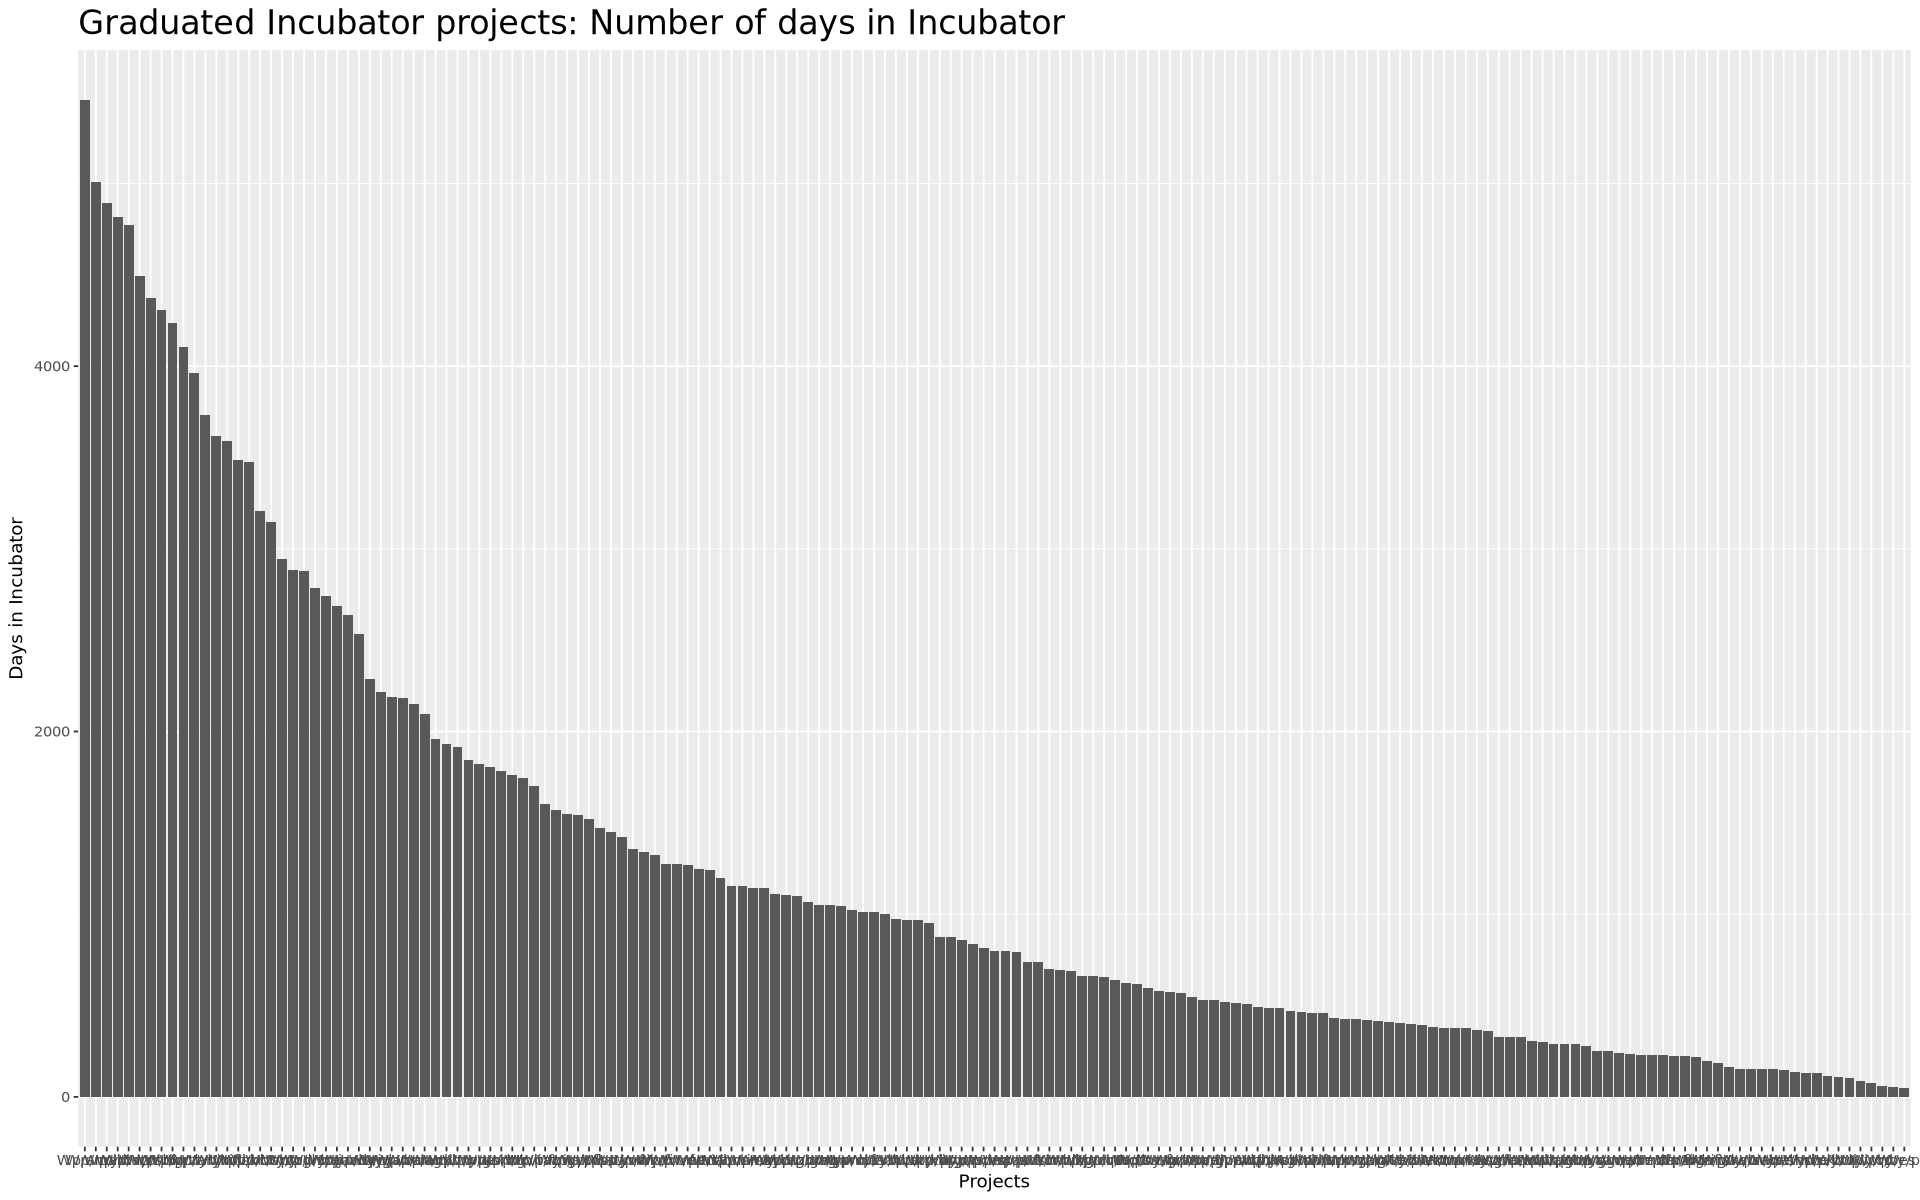

In [151]:
# Range of all graduated Incubator projects
options(repr.plot.width=16, repr.plot.height=10)
df %>%
 ggplot(aes(x=reorder(prefix,-total_days_in_incubator), y=total_days_in_incubator)) +
 geom_bar(stat="identity") + xlab("Projects") +
 theme(plot.title=element_text(size=20)) +
 ylab("Days in Incubator") +
 labs(title="Graduated Incubator projects: Number of days in Incubator")

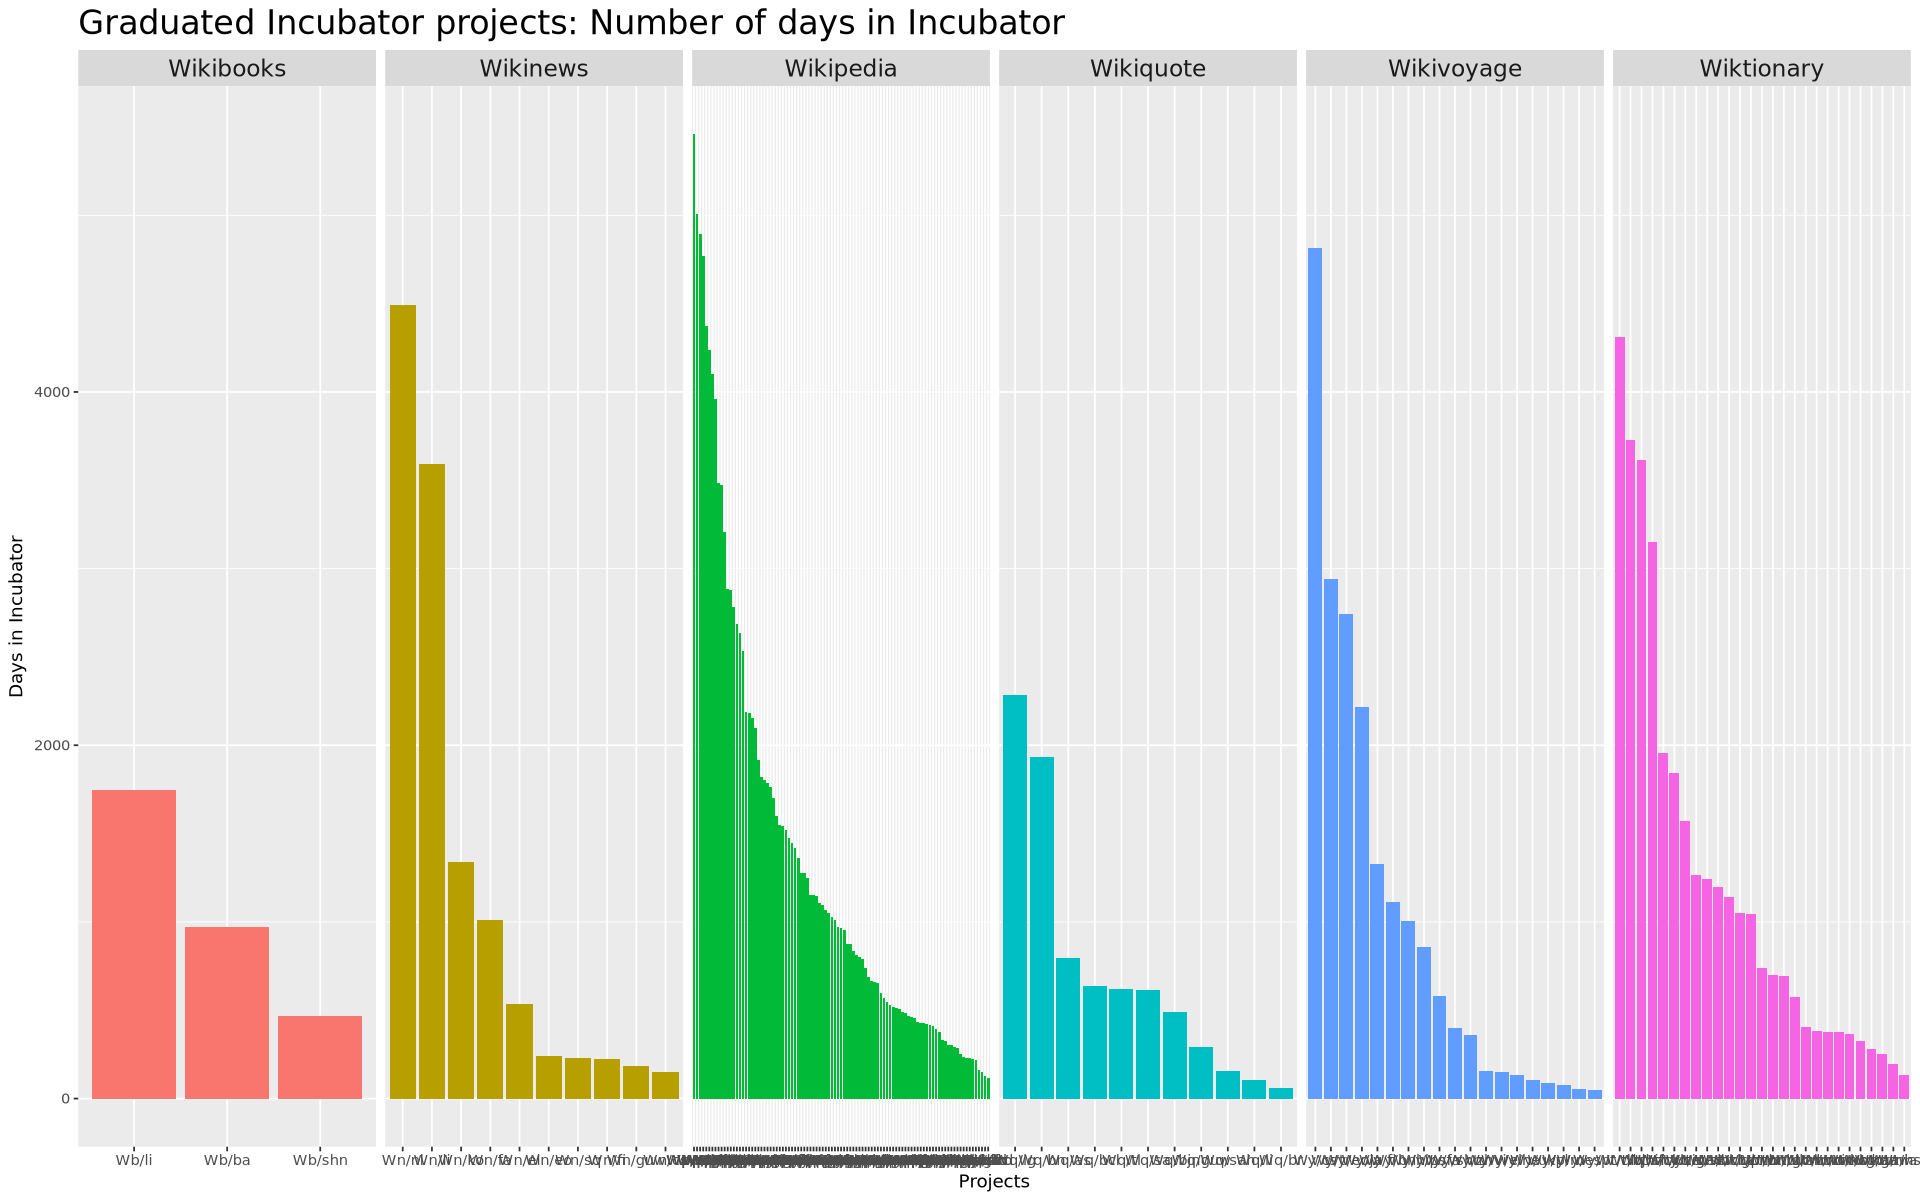

In [152]:
# Range of all graduated Incubator projects, by project type
options(repr.plot.width=16, repr.plot.height=10)
df %>%
 ggplot(aes(x=reorder(prefix,-total_days_in_incubator), y=total_days_in_incubator, fill=project_type)) +
 geom_bar(stat="identity") +
 ylab("Days in Incubator") + xlab("Projects") +
 facet_grid(.~project_type, scales="free_x") + 
 theme(legend.position="none", strip.text=element_text(size=14)) +
 theme(plot.title=element_text(size=20)) +
 labs(title="Graduated Incubator projects: Number of days in Incubator")

In [153]:
# Boxplots of all graduated Incubator projects, by project type
options(repr.plot.width=16, repr.plot.height=8)

# First, add an "All" project type category
df_all <- df
df_all$project_type <- "All"
df_all <- rbind(df, df_all)

# Then, summary stats
summ <- df_all %>% 
  dplyr::group_by(project_type) %>% 
  dplyr::summarize(mean = mean(total_days_in_incubator), median = median(total_days_in_incubator), sd = sd(total_days_in_incubator)) %>%
  dplyr::ungroup()

# Now plot
df_all %>%
 ggplot(aes(x = project_type, y = total_days_in_incubator, color = project_type)) +
# geom_violin() +
 geom_point(position = position_jitter(seed = 1, width = 0.1)) +
 facet_grid(.~project_type, scales="free_x") + 
 geom_label(data = summ, aes(x = project_type, y = median, label = paste0("median: ", median), size=20)) +
 geom_label(data = summ, aes(x = project_type, y = mean, label = paste0("mean: ", round(mean,1)), size=20)) +
 theme(legend.position="none", strip.text=element_text(size=16), plot.title = element_text(size=20),
       plot.caption = element_text(size=12, color="dimgray"), axis.text.x = element_blank(), axis.title.x = element_blank(), 
       axis.title.y = element_text(size=15), axis.text.y = element_text(size=12, color="dark grey")) +
 scale_y_continuous(name="Days in Incubator", breaks=seq(0,5500,365)) +
 scale_color_manual(values = c("dimgray", "#f8766dff", "#b79f00ff", "#00ba39ff", "#03bfc4ff", "#619cffff", "#f564e3ff")) +
 labs(title = "Graduated* Incubator projects: Number of days spent in Incubator (with medians labeled)",
      caption = "July 2024 \n* 'Graduated' refers to projects that have left the Incubator test space, per Language Committee approval, and received their own domain hosted by the Wikimedia Foundation")

`summarise()` has grouped output by 'project_type'. You can override using the
`.groups` argument.


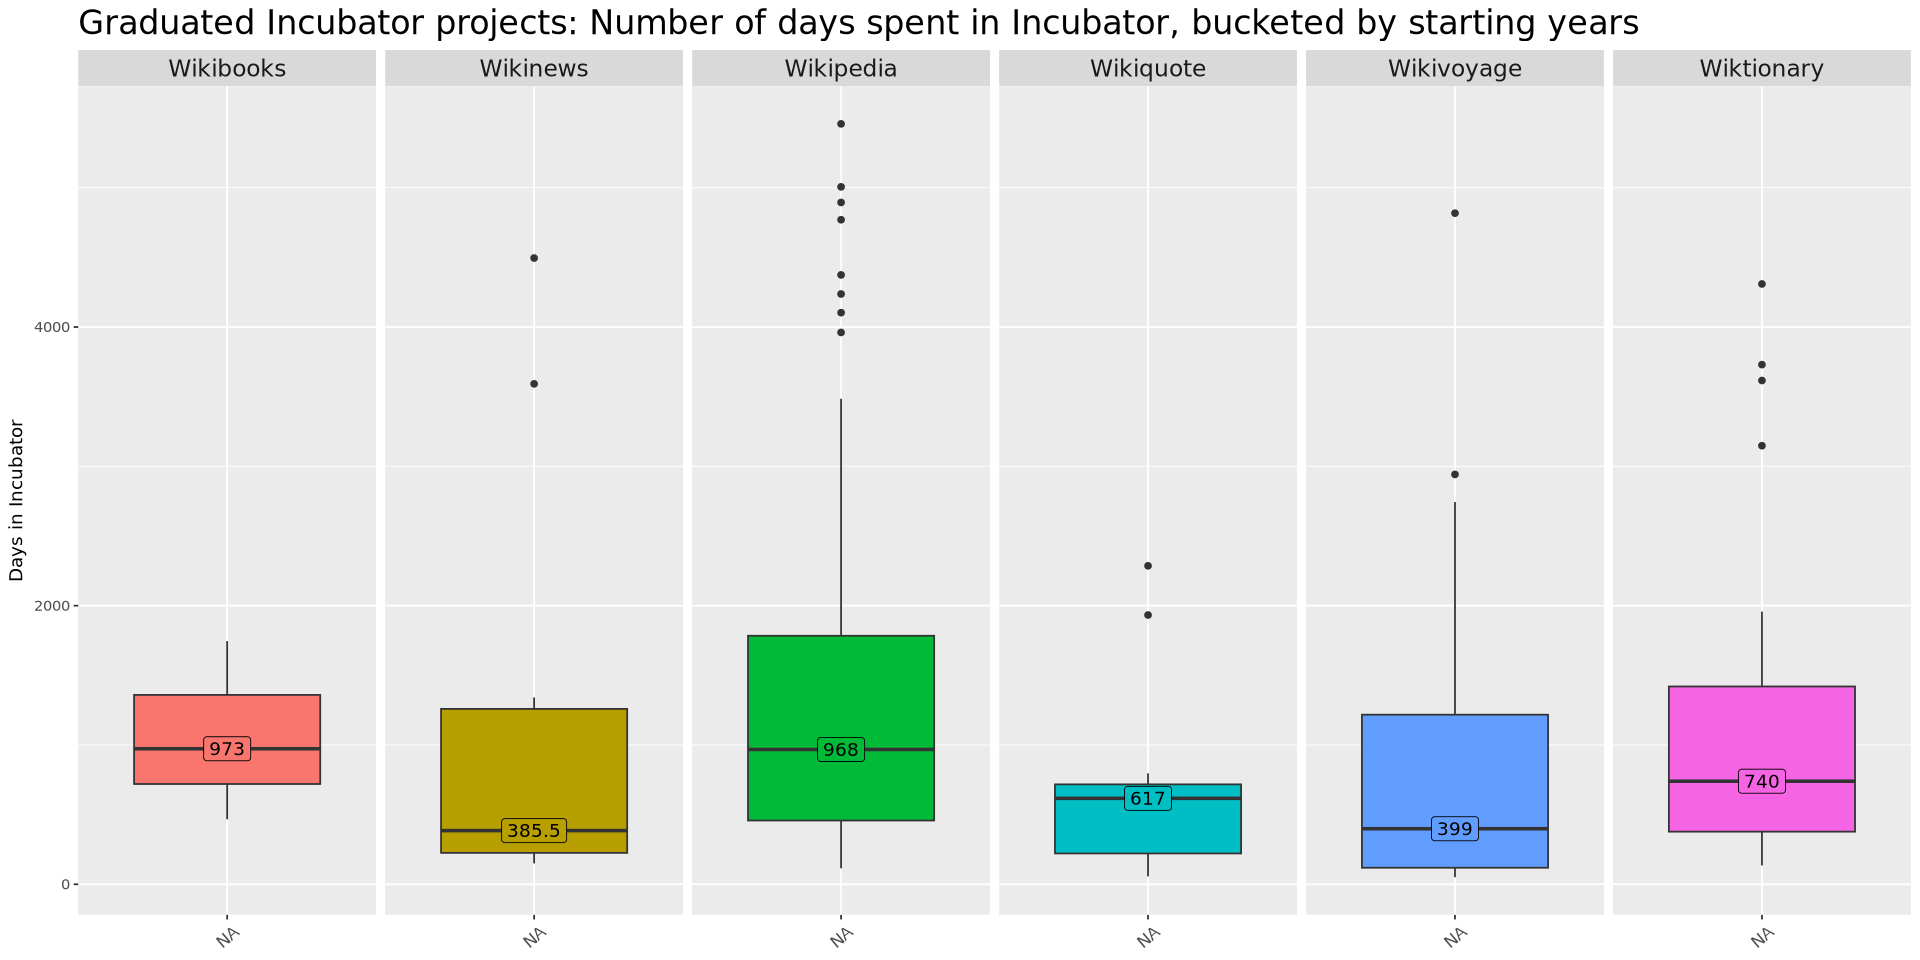

In [154]:
# more time-in-incubator summary stats

summ_prep <- df %>%
  mutate(first_edit_year = format(as.Date(first_edit_timestamp, format="%d/%m/%Y"),"%Y")) 
summ_prep$first_edit_year[summ_prep$first_edit_year>2004 & summ_prep$first_edit_year<2010] <- "2005-2009"
summ_prep$first_edit_year[summ_prep$first_edit_year>2009 & summ_prep$first_edit_year<2015] <- "2010-2014"
summ_prep$first_edit_year[summ_prep$first_edit_year>2014 & summ_prep$first_edit_year<2020] <- "2015-2019"
summ_prep$first_edit_year[summ_prep$first_edit_year>2019 ] <- "2020-pres"

summ <- summ_prep %>% 
  dplyr::group_by(project_type, first_edit_year) %>% 
  dplyr::summarize(mean = mean(total_days_in_incubator), median = median(total_days_in_incubator), sd = sd(total_days_in_incubator)) %>%
  dplyr::ungroup()

# now plot
summ_prep %>%
 ggplot(aes(x = first_edit_year, y = total_days_in_incubator, fill = project_type)) +
 geom_boxplot() +
 facet_wrap(.~project_type, ncol=6) + 
 geom_label(data = summ, aes(x = first_edit_year, y = median, label = median)) +
 theme(legend.position="none", strip.text=element_text(size=14), plot.title = element_text(size=20),
       axis.text.x = element_text(size=10, angle=40, vjust=0.5, hjust=0.5), axis.title.x = element_blank()) +
 ylab("Days in Incubator") +
 labs(title = "Graduated Incubator projects: Number of days spent in Incubator, bucketed by starting years")

## NOTE THAT THE GRADUATE PROJECTS WITH MORE RECENT START DATES WILL ALL HAVE SHORTER LENGTHS, DUE TO THE CURRENT DATE BEING CLOSURE TO THE START OF THE PROJECT
## AND BECAUSE THIS IS ONLY SHOWING GRADUATED PROJECTS AND NOT THE MANY PROJECTS THAT ARE STILL IN THE INCUBATOR (WITH LONGER PAST AND FUTURE TIME SPENT IN INCUBATOR)
## THUS THIS SHOULD NOT BE INTERPRETED AS SHOWING THAT TIME-TO-GRADUATION IS DECREASING

In [155]:
## How many wikis were in the Inubator for more than 3 years (1095 days) before graduating?
nrow(df %>% filter(total_days_in_incubator>1095) %>% 
     arrange(desc(total_days_in_incubator)))

## ..... more than 4 years (1460 days)?
nrow(df %>% filter(total_days_in_incubator>1460) %>% 
     arrange(desc(total_days_in_incubator)))

## ..... more than 5 years (1825 days)?
nrow(df %>% filter(total_days_in_incubator>1825) %>% 
     arrange(desc(total_days_in_incubator)))

[1] 66

[1] 48

[1] 36

In [156]:
## Which projects were in the Inubator for more than 4 years (1460 days)?
head(
    df %>% filter(total_days_in_incubator>1460) %>% 
      select(prefix, language_name, first_edit_timestamp, grad_dt, total_days_in_incubator) %>% 
      arrange(desc(total_days_in_incubator))
    ) 
## removed "head()" for full list

prefix language_name first_edit_timestamp grad_dt    total_days_in_incubator
1 Wp/anp Angika        2004-08-11           2023-03-22 5458                   
2 Wp/mad Madurese      2006-11-27           2020-12-15 5006                   
3 Wp/lld Ladin         2005-08-23           2020-08-17 4894                   
4 Wy/cs  Czech         2006-12-18           2024-07-25 4817                   
5 Wp/dtp Central Dusun 2011-01-22           2024-05-28 4770                   
6 Wn/nl  Dutch         2005-01-28           2017-07-05 4495

In [157]:
# Plot time in incubator
options(repr.plot.width=16, repr.plot.height=10)

## PREP

first_edit <- df %>% 
  select(prefix, language_name, avg_first_edit_5pct, project_type, total_days_in_incubator) %>%
  mutate(type= "1- First edit") %>%
  dplyr::rename(edit = avg_first_edit_5pct) %>%
  mutate(edit = as.Date(edit))
         
grad <- df %>% 
  select(prefix, language_name, grad_dt, project_type, total_days_in_incubator) %>%
  mutate(type= "3- Graduation") %>%
  dplyr::rename(edit = grad_dt) %>%
  mutate(edit = as.Date(edit))


first_to_grad <- rbind(first_edit, grad) ## bind

first_to_grad <- df %>%
  select(prefix, avg_first_edit_5pct) %>%
  right_join(., first_to_grad, by = "prefix") ## re-add first_edit_timestamp column for ordering in plot


## PLOT
first_to_grad %>%
  ggplot(aes(x=reorder(prefix, as.Date(avg_first_edit_5pct)), y=edit, color=project_type, group=prefix)) +
  geom_line() +
  geom_point() +
  coord_flip() +
  facet_grid(.~project_type, scales="free") +
  theme(legend.position = "none",  strip.text=element_text(size=14), axis.title = element_blank(),
       plot.title = element_text(size=20)) +
 labs(title = "Graduated Incubator projects: Distance between first edit and graduation from Incubator")

## NOTE THAT THE GRADUATE PROJECTS WITH MORE RECENT START DATES WILL ALL HAVE SHORTER LENGTHS, DUE TO THE CURRENT DATE BEING CLOSURE TO THE START OF THE PROJECT
## AND BECAUSE THIS IS ONLY SHOWING GRADUATED PROJECTS AND NOT THE MANY PROJECTS THAT ARE STILL IN THE INCUBATOR (WITH LONGER PAST AND FUTURE TIME SPENT IN INCUBATOR)
## THUS THIS SHOULD NOT BE INTERPRETED AS SHOWING THAT TIME-TO-GRADUATION IS DECREASING

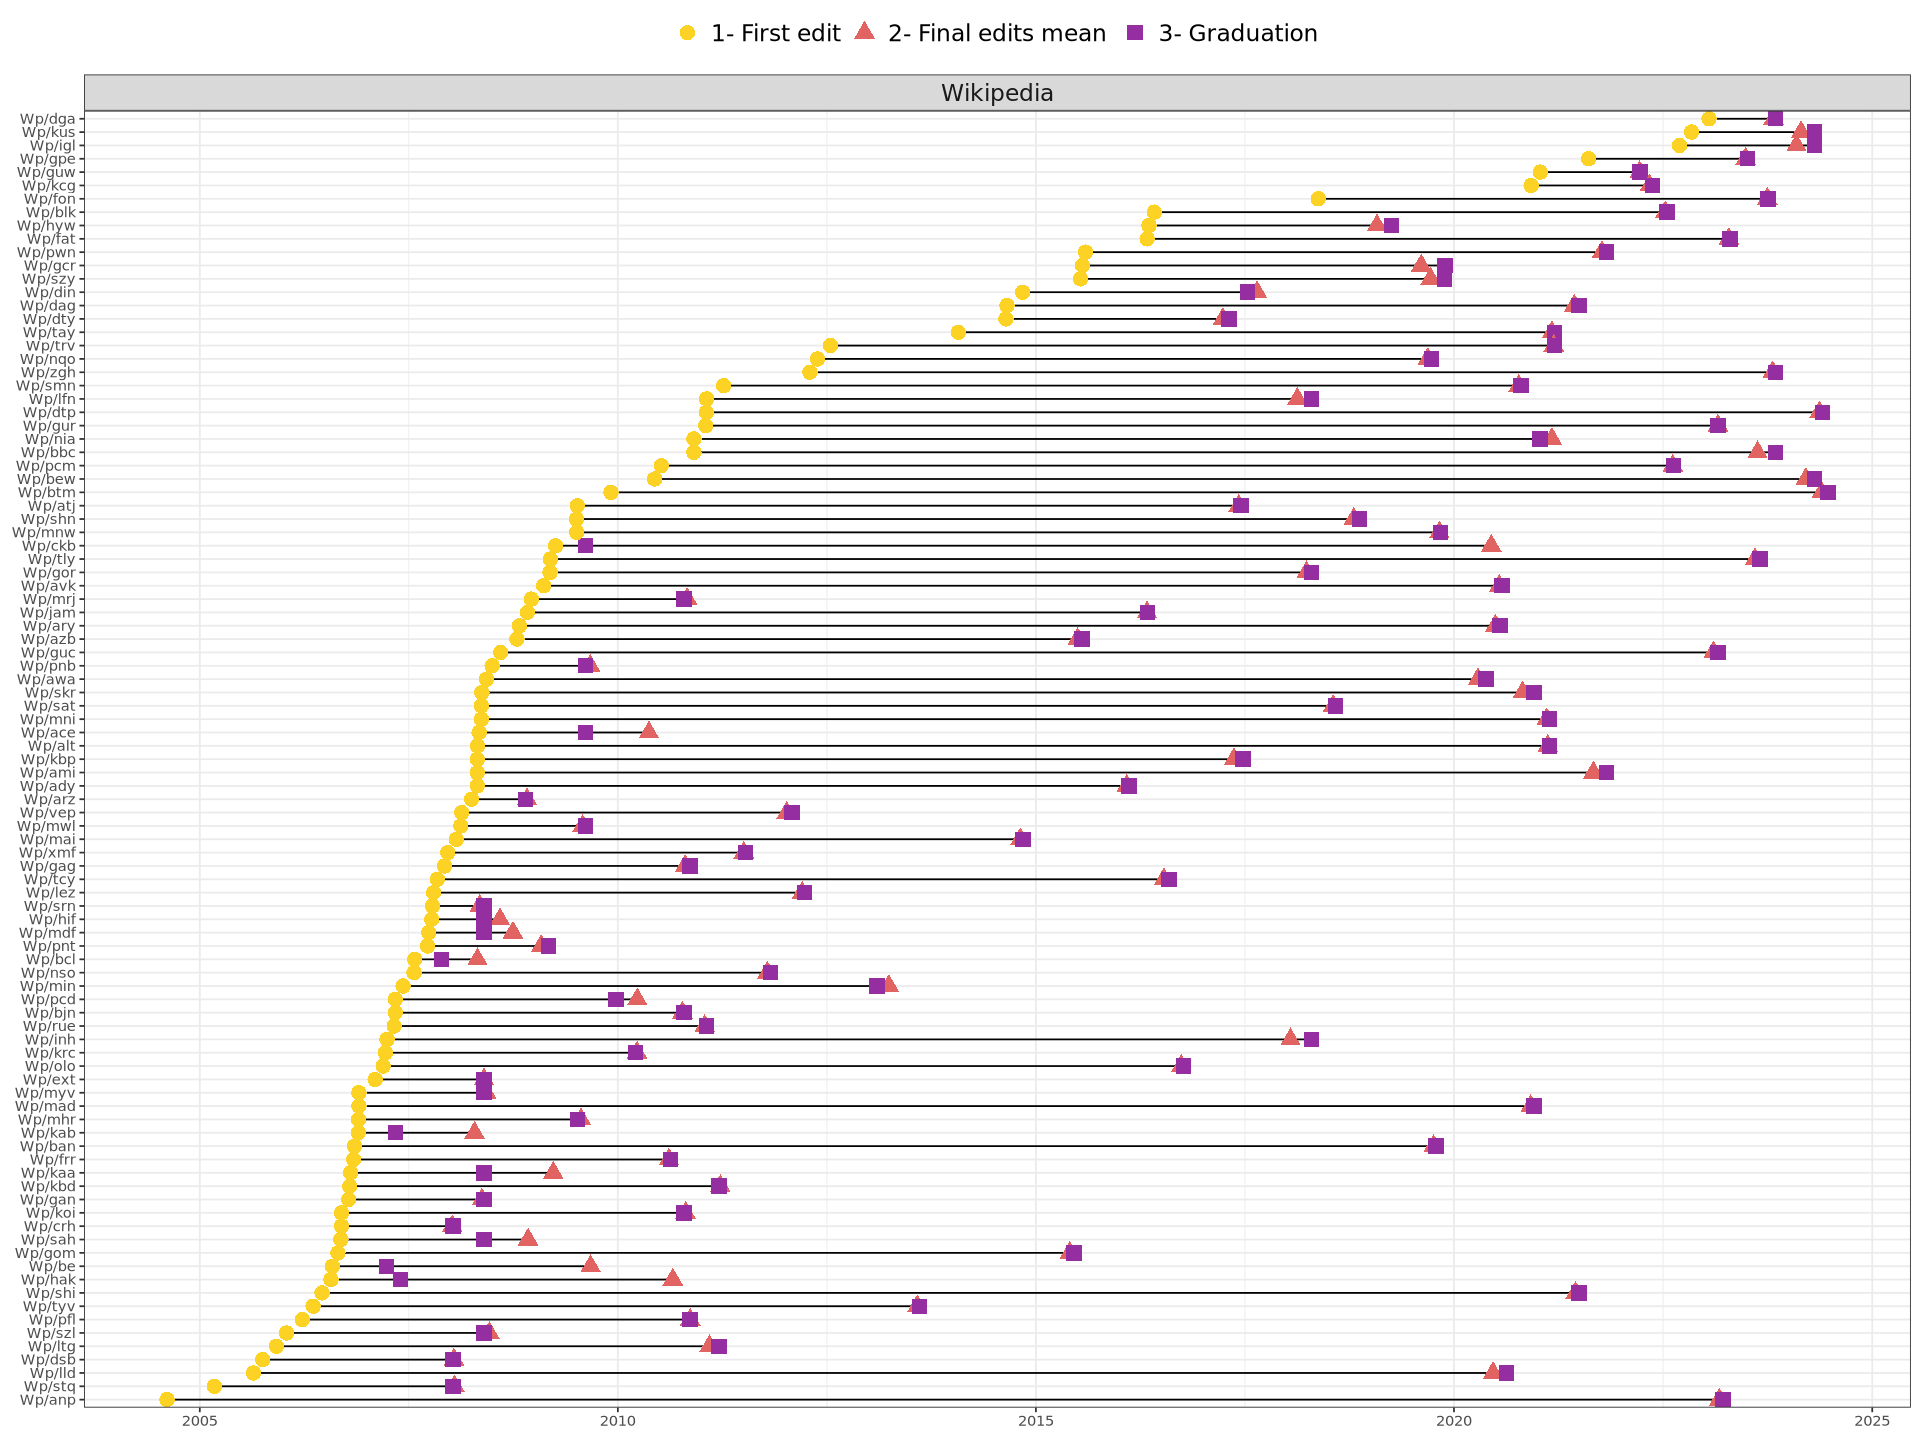

In [158]:
# Plot time in incubator, including gap between the last meaningful edits and graduation
# Wikipedia only

options(repr.plot.width=16, repr.plot.height=12)

## PREP

first_edit <- df %>% 
  select(prefix, language_name, first_edit_timestamp, project_type) %>%
  mutate(first_edit_timestamp==as.Date(first_edit_timestamp)) %>%
  mutate(type= "1- First edit") %>%
  dplyr::rename(edit = first_edit_timestamp) %>%
  mutate(edit = as.Date(edit))
         
last_edits_mean <- df %>% 
  select(prefix, language_name, avg_last_edit_5pct, project_type) %>%
  mutate(avg_last_edit_5pct==as.Date(avg_last_edit_5pct)) %>%
  mutate(type= "2- Final edits mean") %>%
  dplyr::rename(edit = avg_last_edit_5pct)%>%
  mutate(edit = as.Date(edit))

grad <- df %>% 
  select(prefix, language_name, grad_dt, project_type) %>%
  mutate(grad_dt==as.Date(grad_dt)) %>%
  mutate(type= "3- Graduation") %>%
  dplyr::rename(edit = grad_dt)%>%
  mutate(edit = as.Date(edit))


first_to_grad <- rbind(first_edit, last_edits_mean, grad) ## bind

first_to_grad <- df %>%
  select(prefix, first_edit_timestamp) %>%
  right_join(., first_to_grad, by = "prefix") ## re-add first_edit_timestamp column for ordering in plot


## PLOT

first_to_grad %>%
  filter(project_type=="Wikipedia") %>%
  ggplot(aes(x=reorder(prefix, as.Date(first_edit_timestamp)), y=edit, group=prefix)) +
  geom_line() +
  geom_point(aes(color=type, shape=type), size=4) +
  coord_flip() +
  facet_grid(.~project_type) +
#    scale_colour_manual(values = c("#B8DE29", "#55C667", "#404788")) + # from Viridis
     scale_colour_manual(values = c("#FCD225", "#E16462", "#952EA0")) + # from Viridis Magma
     theme_bw() +
  theme(legend.position = "top", legend.text = element_text(size=14), legend.title = element_blank(),
        strip.text=element_text(size=14), axis.title = element_blank()) 